# Ship Detection- Project AIRBUS 2019
## Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations)

In [1]:
BATCH_SIZE = 48
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 900
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 9
MAX_TRAIN_EPOCHS = 99
AUGMENT_BRIGHTNESS = False

Import:
And load files :

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.util import montage as Montage
from skimage.morphology import binary_opening, disk, label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import warnings
montage_rgb = lambda x: np.stack([Montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
warnings.filterwarnings("ignore")
ship_dir = 'D:\Projet Airbus/'
train_image_dir = os.path.join(ship_dir, 'Train')# Images for training
test_image_dir = os.path.join(ship_dir, 'Test')# Images for testing
masks = pd.read_csv(ship_dir + 'train_ship_segmentations_v2.csv') # Markers for ships

os.chdir("D:\Projet Airbus/Train")

Using TensorFlow backend.


Various functions needed to show the images.

In [3]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [4]:
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


## Make sure encode/decode works
Given the process

RLE0  ⟶  Image0  ⟶  RLE1  ⟶  Image1

   Decode  =>   Encode  =>    Decode   
We want to check if/that  Image0=?Image1  We could check the RLEs as well but that is more tedious. Also depending on how the objects have been labeled we might have different counts.

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
0 error


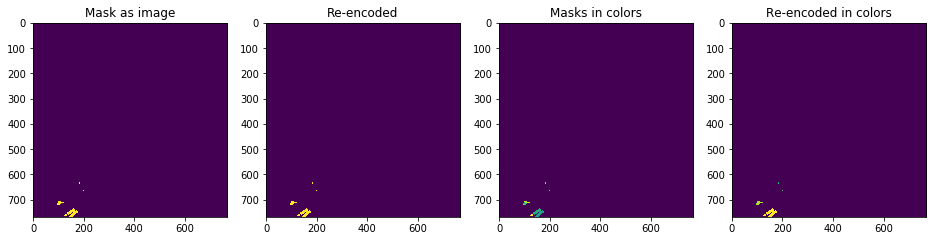

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
rle_0 = masks.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

Function to plot some images and their Mask.

In [6]:
def mask_part(pic):
    '''
    Function that encodes mask for single ship from .csv entry into numpy matrix
    '''
    back = np.zeros(768**2)
    starts = pic.split()[0::2]
    lens = pic.split()[1::2]
    for i in range(len(lens)):
        back[(int(starts[i])-1):(int(starts[i])-1+int(lens[i]))] = 1
    return np.reshape(back, (768, 768, 1))

def is_empty(key):
    '''
    Function that checks if there is a ship in image
    '''
    df = masks[masks['ImageId'] == key].iloc[:,1]
    if len(df) == 1 and type(df.iloc[0]) != str and np.isnan(df.iloc[0]):
        return True
    else:
        return False
    
def masks_all(key):
    '''
    Merges together all the ship markers corresponding to a single image
    '''
    df = masks[masks['ImageId'] == key].iloc[:,1]
    marks= np.zeros((768,768,1))
    if is_empty(key):
        return marks
    else:
        for i in range(len(df)):
            marks += mark_part(df.iloc[i])
        return np.transpose(marks, (1,0,2))

Randomly chosen images with corresponding masks


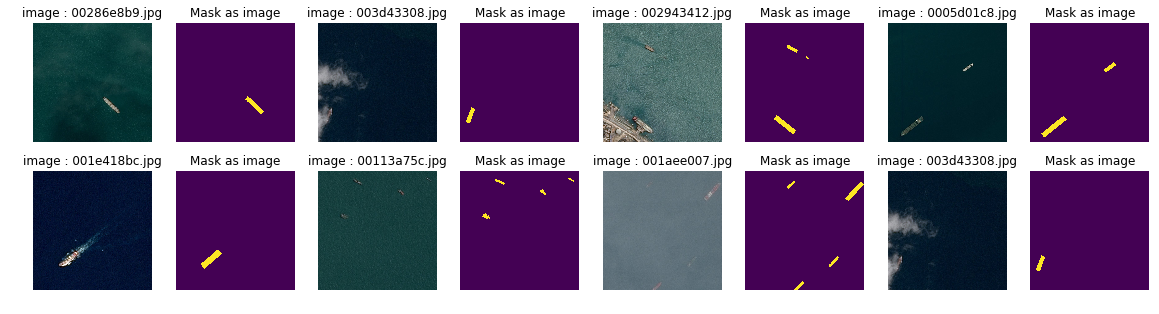

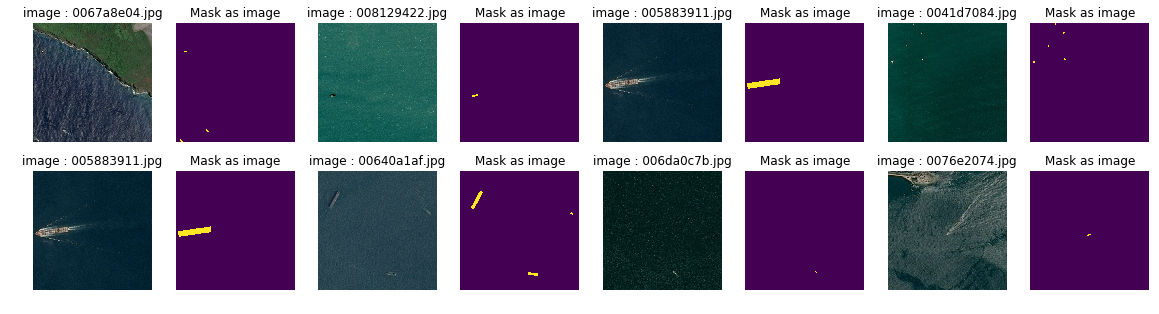

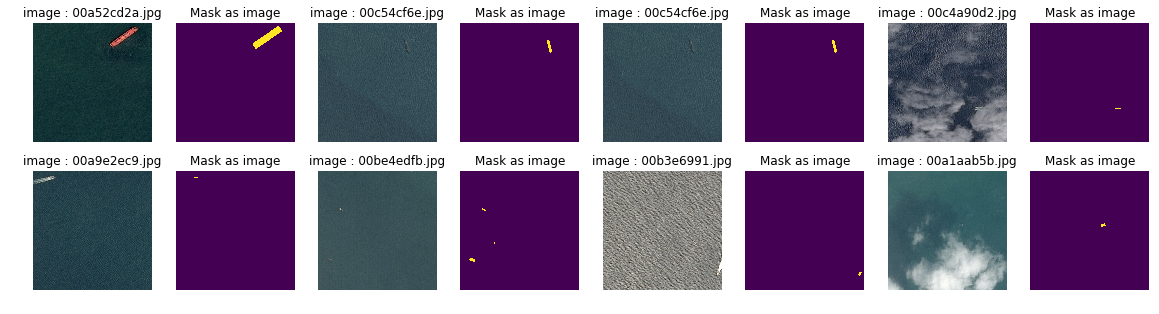

In [7]:
def draw(liste):
    l = int(len(liste)/2)
    plt.figure(figsize = (20,5))
    for i in range(2*l):
        plt.subplot(2,2*l,2*i+1)
        plt.imshow(imread(liste[i]))
        plt.title('image : '+ liste[i])
        plt.axis('off')
        plt.subplot(2,2*l,2*i+2)
        rle_0 = masks.query('ImageId=="' + liste[i]+ '"')['EncodedPixels']
        img_0 = masks_as_image(rle_0)
        plt.imshow(img_0)
        plt.title('Mask as image')
        plt.axis('off')
        #plt.suptitle('Images and corresponding masks', fontsize = 22)
    plt.show()
print('Randomly chosen images with corresponding masks')
draw(np.random.choice([i for i in os.listdir(ship_dir + 'Train/')[:200] if not is_empty(i)], size = 8))
draw(np.random.choice([i for i in os.listdir(ship_dir + 'Train/')[200:400] if not is_empty(i)], size = 8))
draw(np.random.choice([i for i in os.listdir(ship_dir + 'Train/')[400:600] if not is_empty(i)], size = 8))

## Data Augmentation by rotation transformations 

In [8]:
def transform(X, Y):
    '''
    Function for augmenting images. 
    It takes original image and corresponding mask and performs the
    same flipping and rotation transforamtions on both in order to 
    perserve the overlapping of ships and their masks
    '''
# add noise:
    x = np.copy(X)
    y = np.copy(Y)
    x[:,:,0] = x[:,:,0] + np.random.normal(loc=0.0, scale=0.01, size=(768,768))
    x[:,:,1] = x[:,:,1] + np.random.normal(loc=0.0, scale=0.01, size=(768,768))
    x[:,:,2] = x[:,:,2] + np.random.normal(loc=0.0, scale=0.01, size=(768,768))
    # Adding Gaussian noise on each rgb channel; this way we will NEVER get two completely same images.
    # Note that this transformation is not performed on Y 
    x[np.where(x<0)] = 0
    x[np.where(x>1)] = 1
# axes swap:
    if np.random.rand()<0.5: # 0.5 chances for this transformation to occur (same for two below)
        x = np.swapaxes(x, 0,1)
        y = np.swapaxes(y, 0,1)
# vertical flip:
    if np.random.rand()<0.5:
        x = np.flip(x, 0)
        y = np.flip(y, 0)
# horizontal flip:
    if np.random.rand()<0.5:
        x = np.flip(x, 1)
        y = np.flip(y, 1)
    return x, y  

In [9]:
def plot_transformed(file):
    '''
    Plots specified Original image and five augmentations
    (five images created transforming original with function 'transform()')
    '''
    X, Y = plt.imread(file), masks_as_image(masks.query('ImageId=="' + file+ '"')['EncodedPixels'])
    plt.figure(figsize = (19,8))
    plt.subplot(253, title ='Original Image')
    X, Y = plt.imread(file)/255, masks_as_image(masks.query('ImageId=="' + file+ '"')['EncodedPixels'])
    plt.imshow(X)
    plt.axis('off')
    plt.subplot(256, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')
    plt.subplot(257, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')    
    plt.subplot(258, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')
    plt.subplot(259, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')    
    plt.subplot(2,5,10, title ='Transformed Image')
    plt.imshow(transform(X,Y)[0])
    plt.axis('off')
    plt.suptitle(file,x=0.3, y=0.7, verticalalignment ='top', fontsize = 22)
    plt.show()

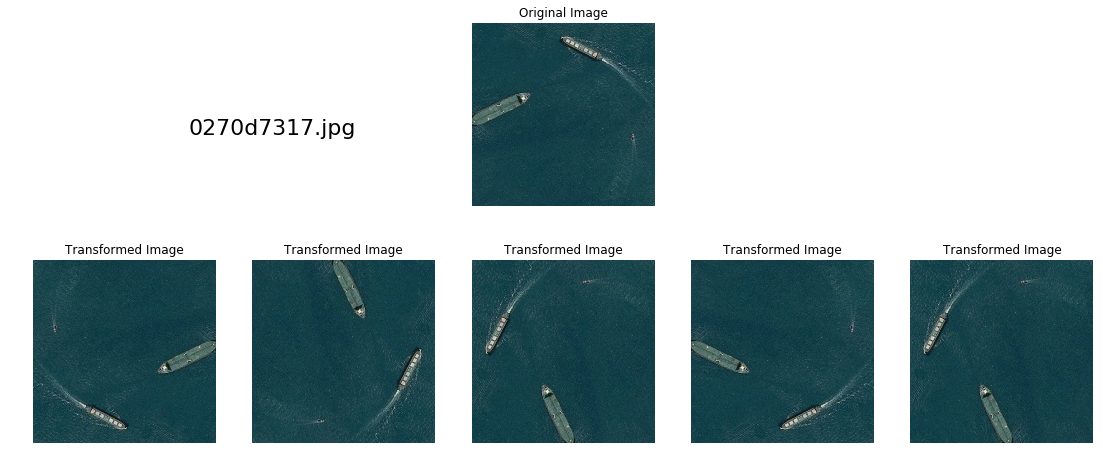

In [10]:
plot_transformed('0270d7317.jpg')

In [11]:
def make_batch(files, batch_size):
    '''
    Creates batches of images and masks in order to feed them to NN
    '''
    X = np.zeros((batch_size, 768, 768, 3))
    Y = np.zeros((batch_size, 768, 768, 1)) # I add 1 here to get 4D batch
    for i in range(batch_size):
        ship = np.random.choice(files)
        X[i] = (io.imread(ship))/255.0 # Original images are in 0-255 range, I want it in 0-1
        Y[i]= Masks_all(ship)
    return X, Y

In [12]:
def Generator(files, batch_size):
    '''
    Generates batches of images and corresponding masks
    '''
    while True:
        X, Y = make_batch(files, batch_size)
        for i in range(batch_size):
            X[i], Y[i] = transform(X[i], Y[i])
        yield X, Y

## Split into training and validation sets
We stratify by the number of boats appearing so we have nice balances in each set

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191289 entries, 0 to 192555
Data columns (total 5 columns):
ImageId         191289 non-null object
ships           191289 non-null int64
has_ship        191289 non-null float64
has_ship_vec    191289 non-null object
file_size_kb    191289 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 8.8+ MB


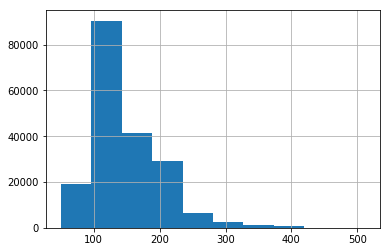

In [48]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join('D:\Projet Airbus/Train', 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.info()

### Examine Number of Ship Images
Here we examine how often ships appear and replace the ones without any ships with 0

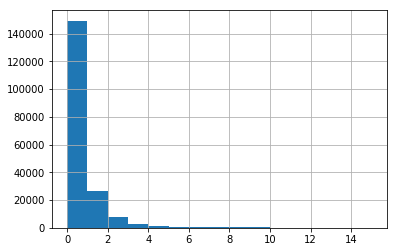

In [14]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

### Undersample Empty Images
Here we undersample the empty images to get a better balanced group with more ships to try and segment

65259 masks
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 65259 entries, (0, 116909) to (15, 192184)
Data columns (total 5 columns):
ImageId         65259 non-null object
ships           65259 non-null int64
has_ship        65259 non-null float64
has_ship_vec    65259 non-null object
file_size_kb    65259 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 3.3+ MB
None


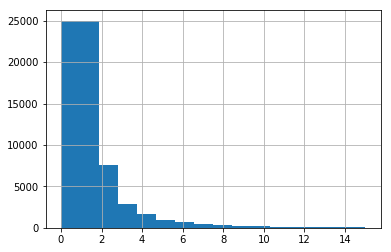

In [51]:
SAMPLES_PER_GROUP = 25000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')
print(balanced_train_df.info())

In [52]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(balanced_train_df, test_size = 0.2)
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

83377 training masks
20675 validation masks


# Decode all the RLEs into Images
We make a generator to produce batches of images

In [53]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (48, 256, 256, 3) 0.0 1.0
y (48, 256, 256, 1) 0 1


TypeError: 'module' object is not callable

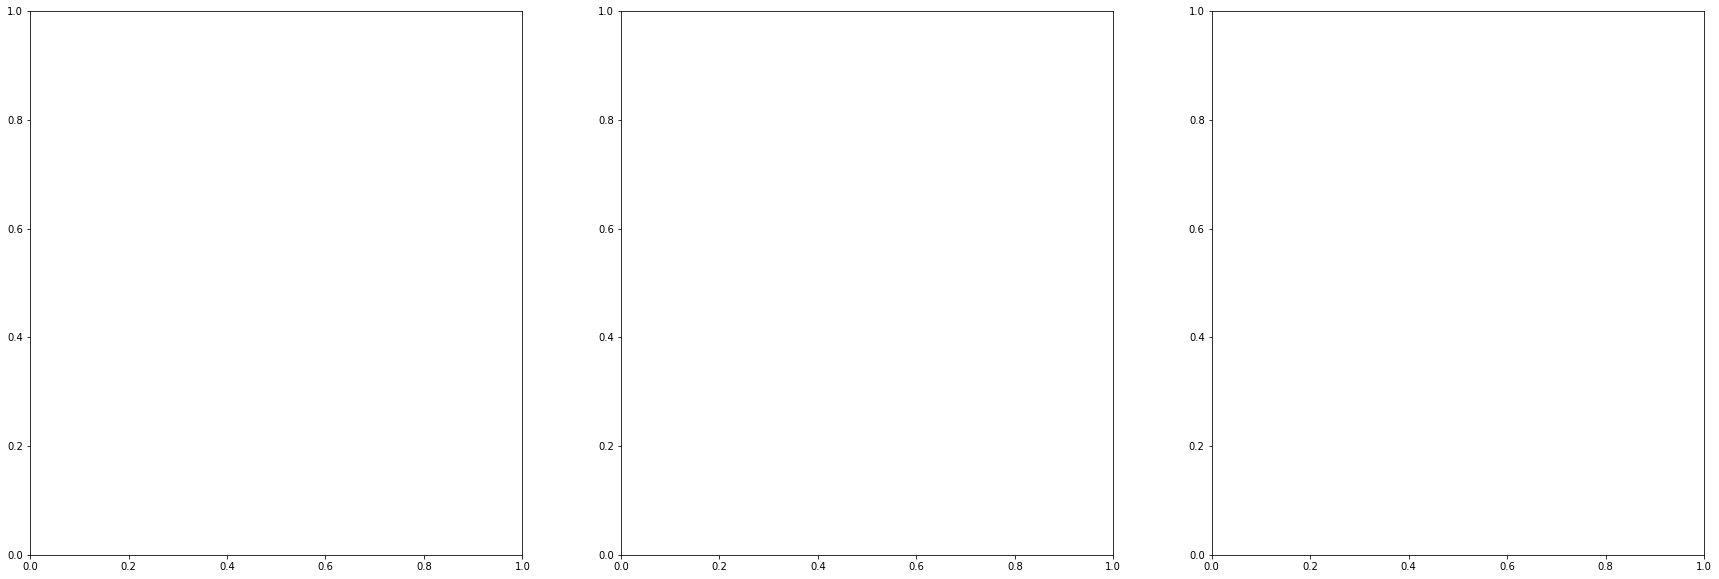

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = Montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

# Validation Set

In [55]:
%%time
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)


(900, 256, 256, 3) (900, 256, 256, 1)
Wall time: 19.8 s


# Data Augmentation by the module of Keras
(ImageDataGenerator from keras.processing)

In [56]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (48, 256, 256, 3) float32 0.0 1.0
y (48, 256, 256, 1) float32 0.0 1.0


TypeError: 'module' object is not callable

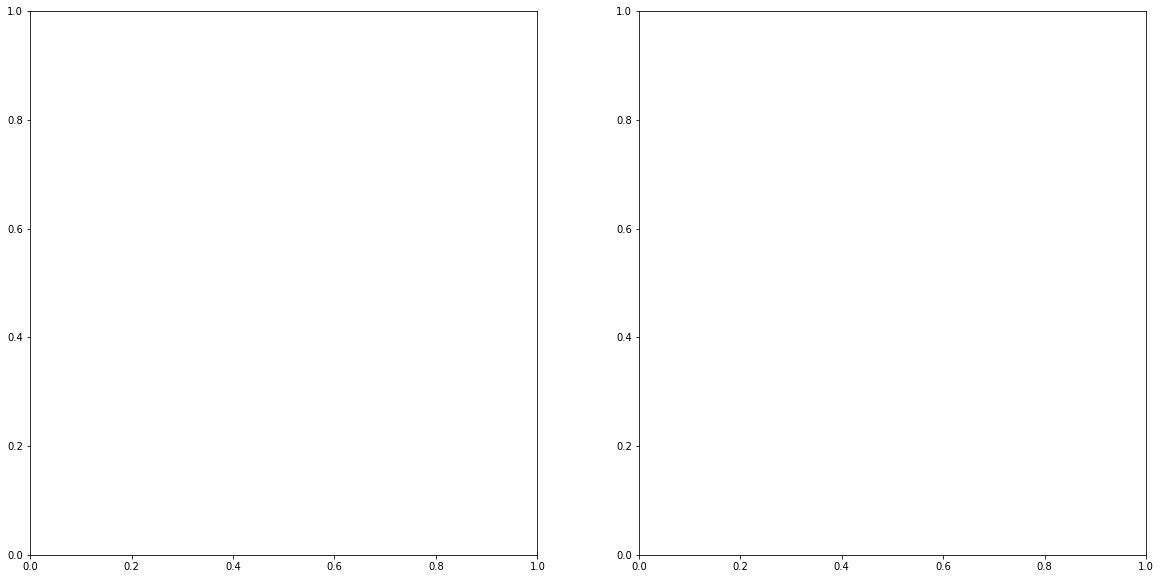

In [57]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

# Build the Model :

In [58]:
# Intersection over Union for Objects
def IoU(y_true, y_pred, tresh=1e-10):
    Intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    Union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - Intersection
    return K.mean( (Intersection + tresh) / (Union + tresh), axis=0)
# Intersection over Union for Background
def back_IoU(y_true, y_pred):
    return IoU(1-y_true, 1-y_pred)
# Loss function
def IoU_loss(in_gt, in_pred):
    #return 2 - back_IoU(in_gt, in_pred) - IoU(in_gt, in_pred)
    return 1 - IoU(in_gt, in_pred)

In [59]:
from keras import models, layers
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
#pp_in_layer = layers.BatchNormalization()(pp_in_layer)
#inputs = Input((768, 768, 3))

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)


outputs = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)

if NET_SCALING is not None:
    outputs = layers.UpSampling2D(NET_SCALING) (outputs)
    
model_1 = models.Model(inputs=[input_img], outputs=[outputs])
model_1.compile(optimizer='adam', loss= IoU_loss, metrics=[IoU, back_IoU])
model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 256, 256, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
gaussian_noise_2 (GaussianNoise (None, 256, 256, 3)  0           average_pooling2d_4[0][0]        
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 8)  224         gaussian_noise_2[0][0]           
__________________________________________________________________________________________________
conv2d_21 

In [60]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

## intersection over union
#def IoU(y_true, y_pred, eps=1e-6):
 #   if np.max(y_true) == 0.0:
  #      return IoU(1-y_true, 1-y_pred) ## empty image; calc IoU of zeros
   # intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    #union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    #return -K.mean( (intersection + eps) / (union + eps), axis=0)

In [61]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('model_1')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=20) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [62]:
def fit():
    model_1.compile(optimizer=Adam(1e-3, decay=1e-10), loss=IoU_loss, metrics=[IoU, back_IoU])
    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(make_image_gen(train_df))
    loss_history = [model_1.fit_generator(aug_gen,
                                 steps_per_epoch=step_count,
                                 epochs=MAX_TRAIN_EPOCHS,
                                 validation_data=(valid_x, valid_y),
                                 callbacks=callbacks_list,
                                workers=1 # the generator is not very thread safe
                                           )]
    return loss_history

while True:
    loss_history = fit()
    if np.min([mh.history['val_loss'] for mh in loss_history]) < 0.75:
        break

Epoch 1/99
9/9 [==============================] - 24s 3s/step - loss: 0.9967 - IoU: 0.0033 - back_IoU: 0.5014 - val_loss: 0.9972 - val_IoU: 0.0028 - val_back_IoU: 0.5058

Epoch 00001: val_loss improved from inf to 0.99725, saving model to model_1_weights.best.hdf5
Epoch 2/99
9/9 [==============================] - 16s 2s/step - loss: 0.9973 - IoU: 0.0027 - back_IoU: 0.5227 - val_loss: 0.9971 - val_IoU: 0.0029 - val_back_IoU: 0.5531

Epoch 00002: val_loss improved from 0.99725 to 0.99707, saving model to model_1_weights.best.hdf5
Epoch 3/99
9/9 [==============================] - 16s 2s/step - loss: 0.9959 - IoU: 0.0041 - back_IoU: 0.6929 - val_loss: 0.9914 - val_IoU: 0.0086 - val_back_IoU: 0.8273

Epoch 00003: val_loss improved from 0.99707 to 0.99142, saving model to model_1_weights.best.hdf5
Epoch 4/99
9/9 [==============================] - 16s 2s/step - loss: 0.9703 - IoU: 0.0297 - back_IoU: 0.7946 - val_loss: 0.9426 - val_IoU: 0.0574 - val_back_IoU: 0.8225

Epoch 00004: val_loss impr

9/9 [==============================] - 18s 2s/step - loss: 0.8798 - IoU: 0.1202 - back_IoU: 0.9581 - val_loss: 0.8570 - val_IoU: 0.1430 - val_back_IoU: 0.9545

Epoch 00030: val_loss improved from 0.85698 to 0.85698, saving model to model_1_weights.best.hdf5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.5315788104430796e-08.
Epoch 31/99
9/9 [==============================] - 18s 2s/step - loss: 0.8785 - IoU: 0.1215 - back_IoU: 0.9606 - val_loss: 0.8570 - val_IoU: 0.1430 - val_back_IoU: 0.9545

Epoch 00031: val_loss improved from 0.85698 to 0.85698, saving model to model_1_weights.best.hdf5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1e-08.
Epoch 32/99
9/9 [==============================] - 19s 2s/step - loss: 0.8531 - IoU: 0.1469 - back_IoU: 0.9600 - val_loss: 0.8570 - val_IoU: 0.1430 - val_back_IoU: 0.9545

Epoch 00032: val_loss improved from 0.85698 to 0.85698, saving model to model_1_weights.best.hdf5
Epoch 33/99
9/9 [==============================] - 18s 

9/9 [==============================] - 18s 2s/step - loss: 0.8646 - IoU: 0.1354 - back_IoU: 0.9606 - val_loss: 0.8570 - val_IoU: 0.1430 - val_back_IoU: 0.9547

Epoch 00060: val_loss improved from 0.85697 to 0.85697, saving model to model_1_weights.best.hdf5
Epoch 61/99
9/9 [==============================] - 18s 2s/step - loss: 0.8677 - IoU: 0.1323 - back_IoU: 0.9600 - val_loss: 0.8570 - val_IoU: 0.1430 - val_back_IoU: 0.9547

Epoch 00061: val_loss improved from 0.85697 to 0.85697, saving model to model_1_weights.best.hdf5
Epoch 62/99
9/9 [==============================] - 18s 2s/step - loss: 0.8585 - IoU: 0.1415 - back_IoU: 0.9635 - val_loss: 0.8570 - val_IoU: 0.1430 - val_back_IoU: 0.9547

Epoch 00062: val_loss improved from 0.85697 to 0.85697, saving model to model_1_weights.best.hdf5
Epoch 63/99
9/9 [==============================] - 18s 2s/step - loss: 0.8813 - IoU: 0.1187 - back_IoU: 0.9623 - val_loss: 0.8570 - val_IoU: 0.1430 - val_back_IoU: 0.9547

Epoch 00063: val_loss improved

9/9 [==============================] - 18s 2s/step - loss: 0.8710 - IoU: 0.1290 - back_IoU: 0.9613 - val_loss: 0.8570 - val_IoU: 0.1430 - val_back_IoU: 0.9548

Epoch 00090: val_loss improved from 0.85696 to 0.85696, saving model to model_1_weights.best.hdf5
Epoch 91/99
9/9 [==============================] - 18s 2s/step - loss: 0.8699 - IoU: 0.1301 - back_IoU: 0.9647 - val_loss: 0.8570 - val_IoU: 0.1430 - val_back_IoU: 0.9548

Epoch 00091: val_loss improved from 0.85696 to 0.85696, saving model to model_1_weights.best.hdf5
Epoch 92/99
9/9 [==============================] - 18s 2s/step - loss: 0.8796 - IoU: 0.1204 - back_IoU: 0.9580 - val_loss: 0.8570 - val_IoU: 0.1430 - val_back_IoU: 0.9549

Epoch 00092: val_loss improved from 0.85696 to 0.85696, saving model to model_1_weights.best.hdf5
Epoch 93/99
9/9 [==============================] - 18s 2s/step - loss: 0.8666 - IoU: 0.1334 - back_IoU: 0.9647 - val_loss: 0.8570 - val_IoU: 0.1430 - val_back_IoU: 0.9549

Epoch 00093: val_loss improved


Epoch 00021: val_loss did not improve from 0.84161

Epoch 00021: ReduceLROnPlateau reducing learning rate to 3.913539212589967e-06.
Epoch 22/99
9/9 [==============================] - 16s 2s/step - loss: 0.8738 - IoU: 0.1262 - back_IoU: 0.9448 - val_loss: 0.8425 - val_IoU: 0.1575 - val_back_IoU: 0.9554

Epoch 00022: val_loss did not improve from 0.84161

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.2914679791720119e-06.
Epoch 23/99
9/9 [==============================] - 16s 2s/step - loss: 0.8587 - IoU: 0.1413 - back_IoU: 0.9405 - val_loss: 0.8422 - val_IoU: 0.1578 - val_back_IoU: 0.9548

Epoch 00023: val_loss did not improve from 0.84161

Epoch 00023: ReduceLROnPlateau reducing learning rate to 4.2618441511876884e-07.
Epoch 24/99
9/9 [==============================] - 16s 2s/step - loss: 0.8544 - IoU: 0.1456 - back_IoU: 0.9549 - val_loss: 0.8421 - val_IoU: 0.1579 - val_back_IoU: 0.9547

Epoch 00024: val_loss did not improve from 0.84161

Epoch 00024: ReduceLROnPlateau re

9/9 [==============================] - 12s 1s/step - loss: 0.8654 - IoU: 0.1346 - back_IoU: 0.9865 - val_loss: 0.8360 - val_IoU: 0.1640 - val_back_IoU: 0.9859

Epoch 00014: val_loss did not improve from 0.83569

Epoch 00014: ReduceLROnPlateau reducing learning rate to 4.2618441511876884e-07.
Epoch 15/99
9/9 [==============================] - 12s 1s/step - loss: 0.8664 - IoU: 0.1336 - back_IoU: 0.9858 - val_loss: 0.8360 - val_IoU: 0.1640 - val_back_IoU: 0.9859

Epoch 00015: val_loss did not improve from 0.83569

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.4064085661402716e-07.
Epoch 16/99
9/9 [==============================] - 12s 1s/step - loss: 0.8500 - IoU: 0.1500 - back_IoU: 0.9860 - val_loss: 0.8360 - val_IoU: 0.1640 - val_back_IoU: 0.9859

Epoch 00016: val_loss did not improve from 0.83569

Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.641148052542121e-08.
Epoch 17/99
9/9 [==============================] - 12s 1s/step - loss: 0.8458 - IoU: 0.1542 - back

9/9 [==============================] - 15s 2s/step - loss: 0.8522 - IoU: 0.1478 - back_IoU: 0.9627 - val_loss: 0.8334 - val_IoU: 0.1666 - val_back_IoU: 0.9653

Epoch 00015: val_loss did not improve from 0.83247

Epoch 00015: ReduceLROnPlateau reducing learning rate to 1e-08.
Epoch 16/99
9/9 [==============================] - 15s 2s/step - loss: 0.8653 - IoU: 0.1347 - back_IoU: 0.9657 - val_loss: 0.8334 - val_IoU: 0.1666 - val_back_IoU: 0.9653

Epoch 00016: val_loss did not improve from 0.83247
Epoch 17/99
9/9 [==============================] - 15s 2s/step - loss: 0.8733 - IoU: 0.1267 - back_IoU: 0.9631 - val_loss: 0.8334 - val_IoU: 0.1666 - val_back_IoU: 0.9653

Epoch 00017: val_loss did not improve from 0.83247
Epoch 18/99
9/9 [==============================] - 15s 2s/step - loss: 0.8401 - IoU: 0.1599 - back_IoU: 0.9672 - val_loss: 0.8334 - val_IoU: 0.1666 - val_back_IoU: 0.9653

Epoch 00018: val_loss did not improve from 0.83247
Epoch 19/99
9/9 [==============================] - 15s 

9/9 [==============================] - 15s 2s/step - loss: 0.8629 - IoU: 0.1371 - back_IoU: 0.9831 - val_loss: 0.8320 - val_IoU: 0.1680 - val_back_IoU: 0.9847

Epoch 00022: val_loss did not improve from 0.83098
Epoch 23/99
9/9 [==============================] - 15s 2s/step - loss: 0.8559 - IoU: 0.1441 - back_IoU: 0.9850 - val_loss: 0.8320 - val_IoU: 0.1680 - val_back_IoU: 0.9847

Epoch 00023: val_loss did not improve from 0.83098
Epoch 24/99
9/9 [==============================] - 15s 2s/step - loss: 0.8550 - IoU: 0.1450 - back_IoU: 0.9825 - val_loss: 0.8320 - val_IoU: 0.1680 - val_back_IoU: 0.9847

Epoch 00024: val_loss did not improve from 0.83098
Epoch 25/99
9/9 [==============================] - 15s 2s/step - loss: 0.8311 - IoU: 0.1689 - back_IoU: 0.9826 - val_loss: 0.8320 - val_IoU: 0.1680 - val_back_IoU: 0.9847

Epoch 00025: val_loss did not improve from 0.83098
Epoch 26/99
9/9 [==============================] - 15s 2s/step - loss: 0.8506 - IoU: 0.1494 - back_IoU: 0.9867 - val_los


Epoch 00024: val_loss did not improve from 0.83098
Epoch 00024: early stopping
Epoch 1/99
9/9 [==============================] - 23s 3s/step - loss: 0.8397 - IoU: 0.1603 - back_IoU: 0.9870 - val_loss: 0.8282 - val_IoU: 0.1718 - val_back_IoU: 0.9871

Epoch 00001: val_loss improved from 0.83098 to 0.82819, saving model to model_1_weights.best.hdf5
Epoch 2/99
9/9 [==============================] - 15s 2s/step - loss: 0.8760 - IoU: 0.1240 - back_IoU: 0.9771 - val_loss: 0.8305 - val_IoU: 0.1695 - val_back_IoU: 0.9918

Epoch 00002: val_loss did not improve from 0.82819

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00033000001567415896.
Epoch 3/99
9/9 [==============================] - 15s 2s/step - loss: 0.8324 - IoU: 0.1676 - back_IoU: 0.9952 - val_loss: 0.8307 - val_IoU: 0.1693 - val_back_IoU: 0.9911

Epoch 00003: val_loss did not improve from 0.82819

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010890000325161964.
Epoch 4/99
9/9 [===========================

9/9 [==============================] - 15s 2s/step - loss: 0.8290 - IoU: 0.1710 - back_IoU: 0.9881 - val_loss: 0.8264 - val_IoU: 0.1736 - val_back_IoU: 0.9872

Epoch 00010: val_loss did not improve from 0.82560

Epoch 00010: ReduceLROnPlateau reducing learning rate to 3.913539212589967e-06.
Epoch 11/99
9/9 [==============================] - 15s 2s/step - loss: 0.8409 - IoU: 0.1591 - back_IoU: 0.9877 - val_loss: 0.8264 - val_IoU: 0.1736 - val_back_IoU: 0.9872

Epoch 00011: val_loss did not improve from 0.82560

Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.2914679791720119e-06.
Epoch 12/99
9/9 [==============================] - 15s 2s/step - loss: 0.8045 - IoU: 0.1955 - back_IoU: 0.9886 - val_loss: 0.8264 - val_IoU: 0.1736 - val_back_IoU: 0.9872

Epoch 00012: val_loss did not improve from 0.82560

Epoch 00012: ReduceLROnPlateau reducing learning rate to 4.2618441511876884e-07.
Epoch 13/99
9/9 [==============================] - 15s 2s/step - loss: 0.8375 - IoU: 0.1625 - back

KeyboardInterrupt: 

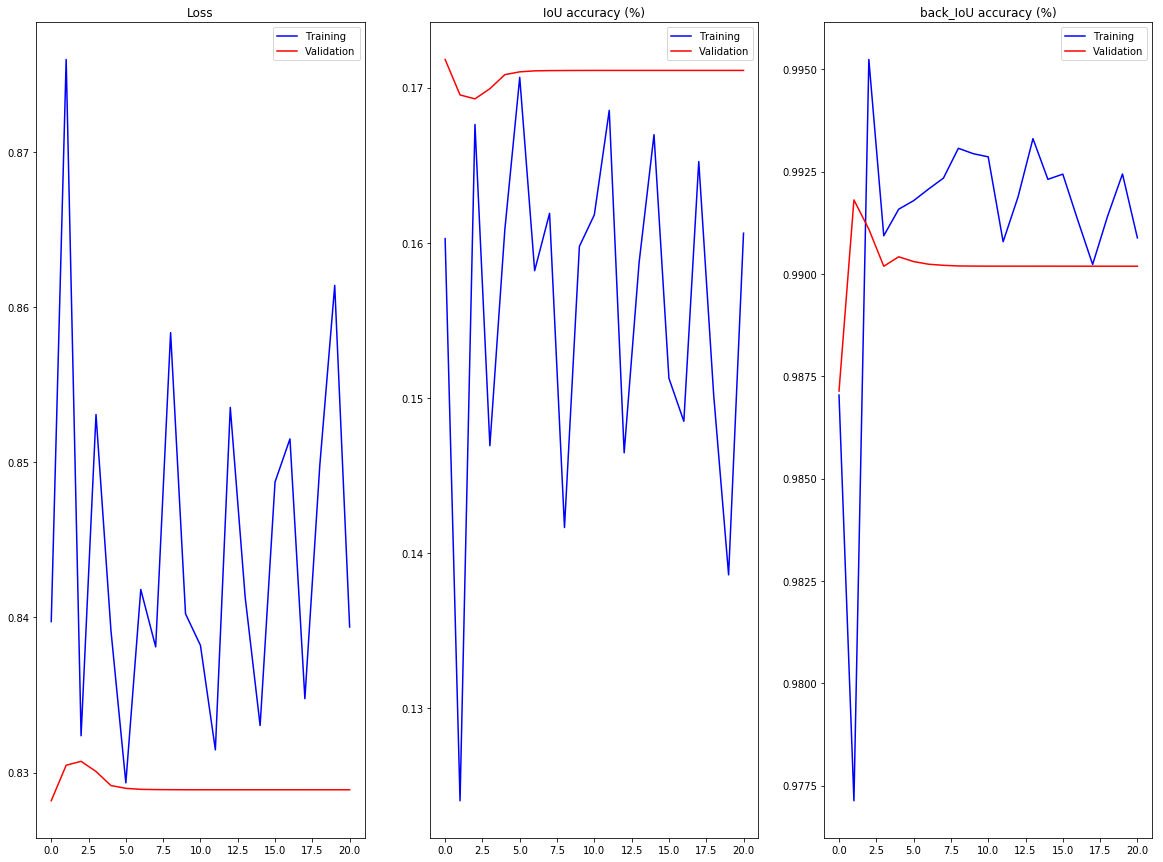

In [63]:
def show_loss(loss_history):
    epochs = np.concatenate([mh.epoch for mh in loss_history])
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 15))
    
    _ = ax1.plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')
    
    _ = ax2.plot(epochs, np.concatenate([mh.history['IoU'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_IoU'] for mh in loss_history]), 'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('IoU accuracy (%)')
    
    _ = ax3.plot(epochs, np.concatenate([mh.history['back_IoU'] for mh in loss_history]), 'b-',
                 epochs, np.concatenate([mh.history['val_back_IoU'] for mh in loss_history]), 'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('back_IoU accuracy (%)')

show_loss(loss_history)

In [64]:
model_1.load_weights(weight_path)
model_1.save('model_1.h5')

In [65]:
pred_y = model_1.predict(valid_x)
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

(900, 256, 256, 1) 1.36089e-07 0.000438673 0.0131131


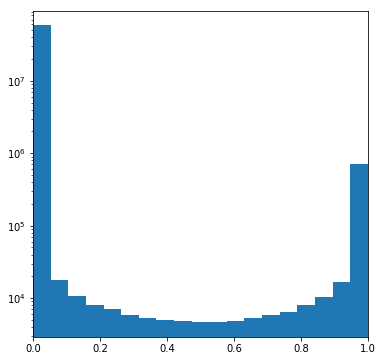

In [66]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log', nonposy='clip')

## Prepare Full Resolution Model
Here we account for the scaling so everything can happen in the model itself

In [67]:

if IMG_SCALING is not None:
    fullres_model = models.Sequential()
    fullres_model.add(layers.AvgPool2D(IMG_SCALING, input_shape = (None, None, 3)))
    fullres_model.add(model_1)
    fullres_model.add(layers.UpSampling2D(IMG_SCALING))
else:
    fullres_model = model_1
fullres_model.save('fullres_model_1.h5')

# Visualisation of predictions

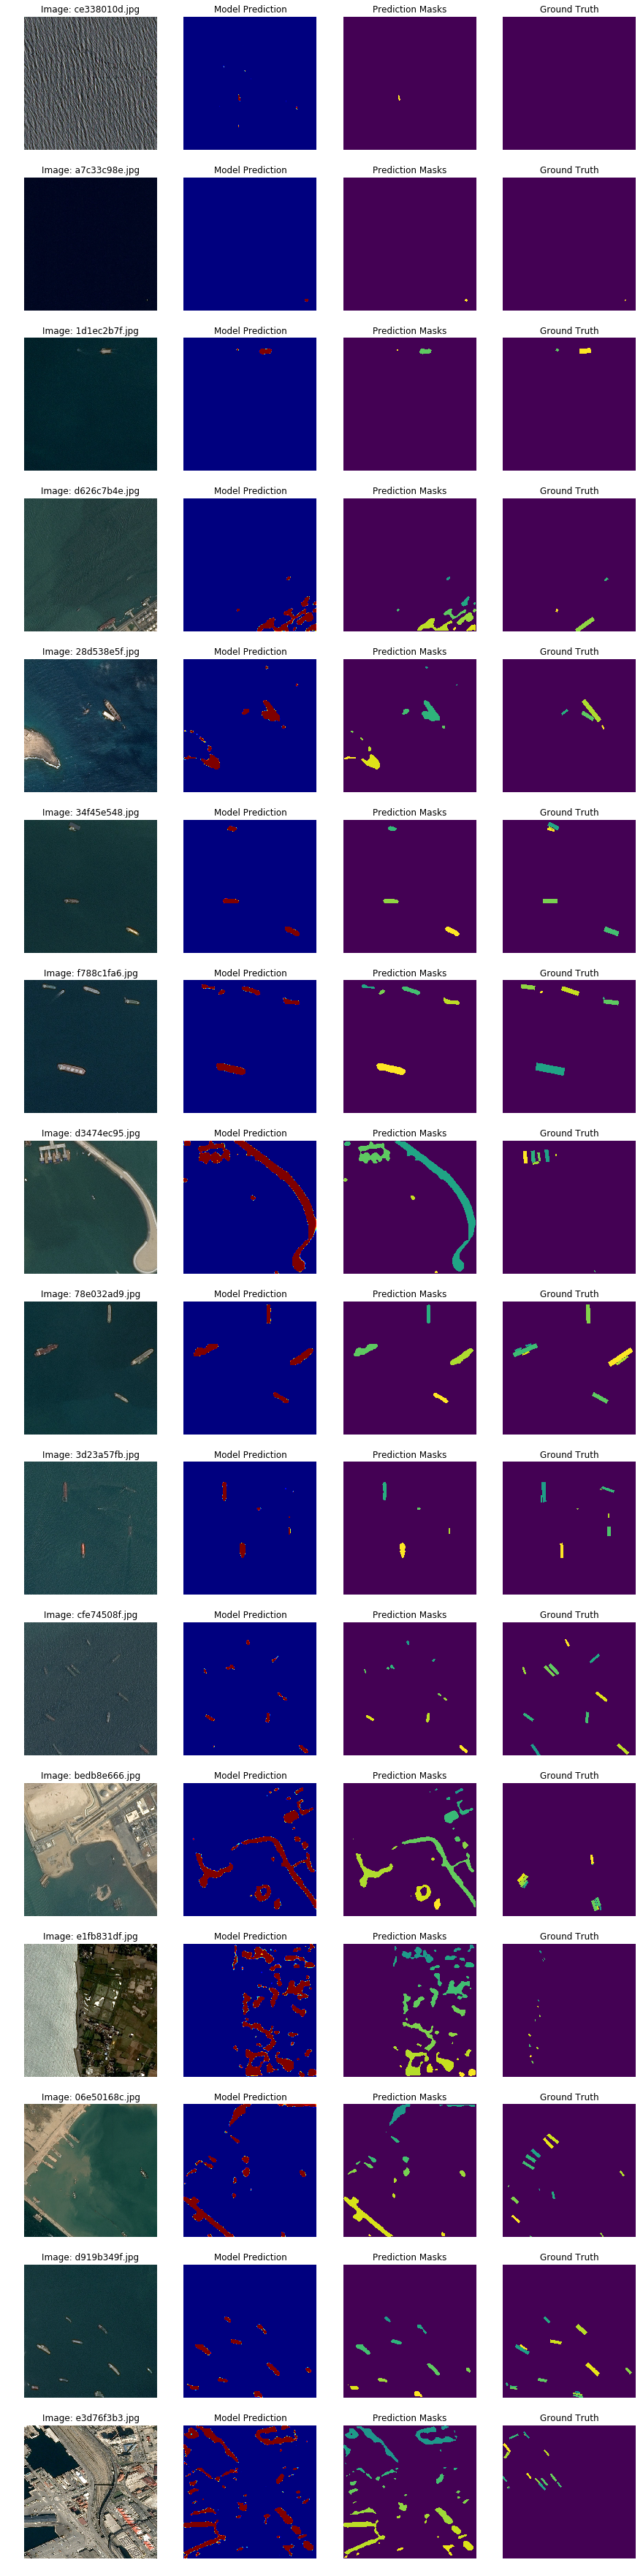

In [68]:
from matplotlib.cm import get_cmap
def raw_prediction(img, path=test_image_dir):
    c_img = imread(os.path.join(path, img))
    c_img = np.expand_dims(c_img, 0)/255.0
    cur_seg = fullres_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=test_image_dir):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

## Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, train_image_dir)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]))
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks.query('ImageId=="{}"'.format(c_img_name))['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')